Take in athlete PR
Convert to percentage of world record
Create other expected perfomances for different races
Plot on graph
Take GAP of Segment
Plot gap on graph, see if over or under curve

In [2]:
import datetime
WR_800 = datetime.timedelta(minutes=1,seconds=40)
WR_MILE = datetime.timedelta(minutes=3,seconds=43)
WR_2K = datetime.timedelta(minutes=4,seconds=44) 
WR_3K = datetime.timedelta(minutes=7,seconds=20)
WR_5K = datetime.timedelta(minutes=12,seconds=35)
WR_10K = datetime.timedelta(minutes=26,seconds=24)
WR_10M = datetime.timedelta(minutes=44,seconds=24)
WR_MARATHON = datetime.timedelta(hours=2,minutes=1,seconds=39)

def pr_to_wr_percentage(athlete_pr:datetime.time):
    # assume 5k for now
    # TODO allow for other PR entry
    percentage_of_wr =  WR_5K.total_seconds() / athlete_pr.total_seconds()
    return percentage_of_wr

def get_equivalent_time_all_records(wr_percentage):
    t_800 = WR_800.total_seconds() * wr_percentage
    t_mile = WR_MILE.total_seconds() * wr_percentage
    t_2k = WR_2K.total_seconds() * wr_percentage
    t_5k = WR_5K.total_seconds() * wr_percentage
    t_10k = WR_10K.total_seconds() * wr_percentage
    t_10m = WR_10M.total_seconds() * wr_percentage
    t_mara = WR_MARATHON.total_seconds() * wr_percentage
    return t_800,t_mile,t_2k,t_5k,t_10k,t_10m,t_mara


In [3]:
pr = datetime.timedelta(minutes=14,seconds=46)
percentage = pr_to_wr_percentage(pr)

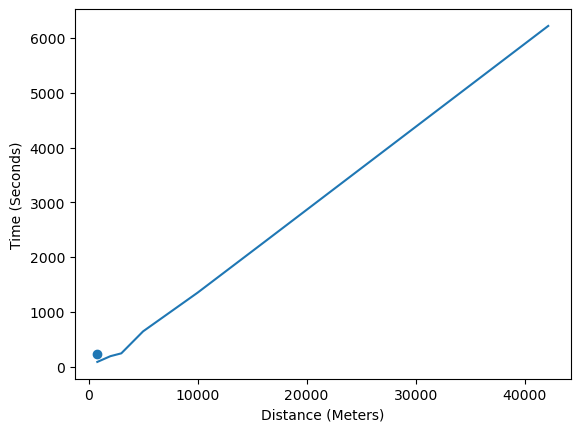

In [9]:
from matplotlib import pyplot as plt
def graph_distance_v_time(equivalent_event_times):
    meters = [800,2000,3000,5000,10000,16093.4,42164.81]
    time = equivalent_event_times
    plt.xlabel("Distance (Meters)")
    plt.ylabel("Time (Seconds)")
    # plotting a random point for comparison
    # TODO find a way to check if above or below line instantly
    plt.scatter([800],[225])
    plt.plot(meters,time)
    plt.show()

graph_distance_v_time(get_equivalent_time_all_records(percentage))
    


